# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve
import seaborn as sn

In [2]:
df = pd.read_csv("../data/Titanic - Machine Learning from Disaster/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# Fix missing data and convert to numerical
age_imputer = make_pipeline(SimpleImputer(strategy="mean"))
imputer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), (OneHotEncoder(handle_unknown="ignore")))

In [58]:
preprocessor = make_column_transformer((age_imputer, ["Age"]),
                                      (imputer, ["Cabin", "Embarked", "Name", "Sex", "Ticket", "Fare"]),
                                      remainder="passthrough", sparse_threshold=0)

In [59]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
model = make_pipeline((preprocessor), (RandomForestClassifier()))

In [64]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['Age']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cabin', 'Embarked', 'Name',
                                                   'Sex', 'Ticket',
                                                   'Fare'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [65]:
model.score(X_test, y_test)

0.8435754189944135

In [66]:
dump(model, "titanic_model.joblib")

['titanic_model.joblib']

In [8]:
# Load the model
model = load("titanic_model.joblib")

In [70]:
y_preds = model.predict(X_test)

In [71]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       119
           1       0.79      0.73      0.76        60

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



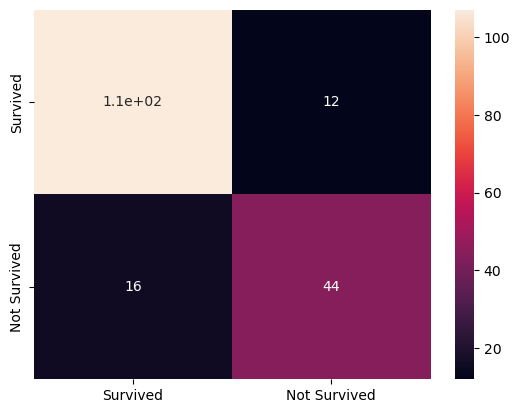

In [77]:
cm = confusion_matrix(y_test, y_preds)
sn.heatmap(cm, annot=True, fmt=".2g", xticklabels=["Survived", "Not Survived"], yticklabels=["Survived", "Not Survived"]);

In [78]:
cm

array([[107,  12],
       [ 16,  44]], dtype=int64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


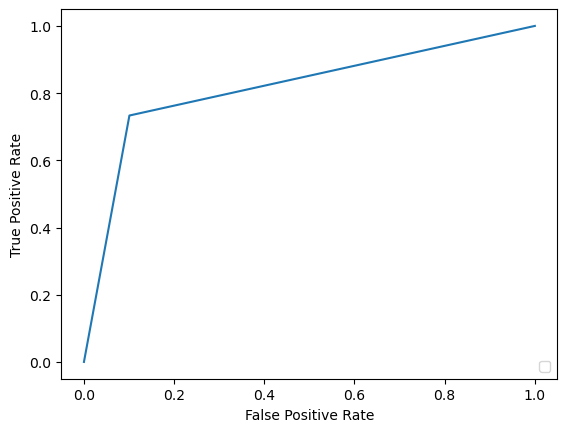

In [81]:
fpr, tpr, threshold = roc_curve(y_test, y_preds)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

# Now lets look at data and predict the actual y data

In [11]:
test_df = pd.read_csv("../data/Titanic - Machine Learning from Disaster/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [43]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [68]:
y_preds = model.predict(test_df)

In [69]:
test_df["Survived"] = pd.Series(y_preds)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


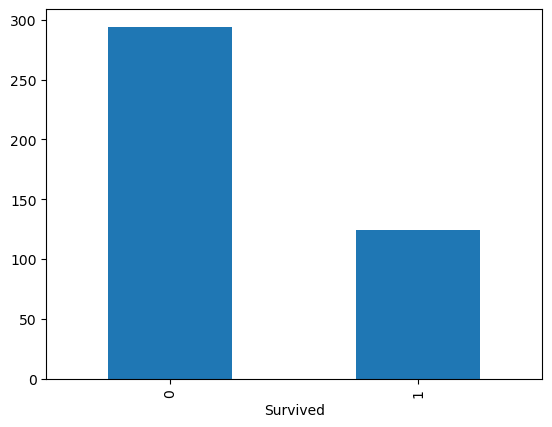

In [83]:
test_df["Survived"].value_counts().plot(kind="bar");

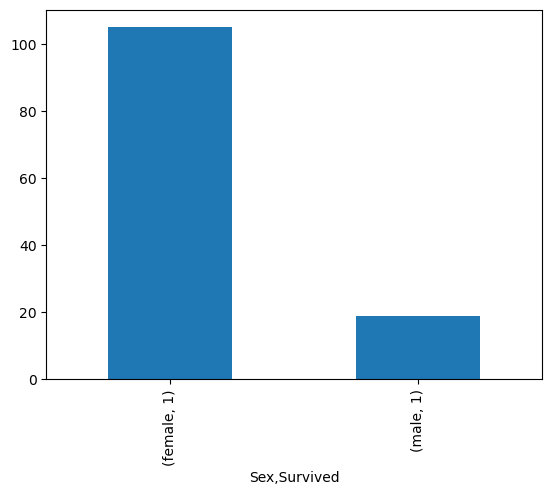

In [87]:
survived = test_df[test_df["Survived"] == 1]
gender_survived = survived.groupby("Sex")
gender_survived["Survived"].value_counts().plot(kind="bar");

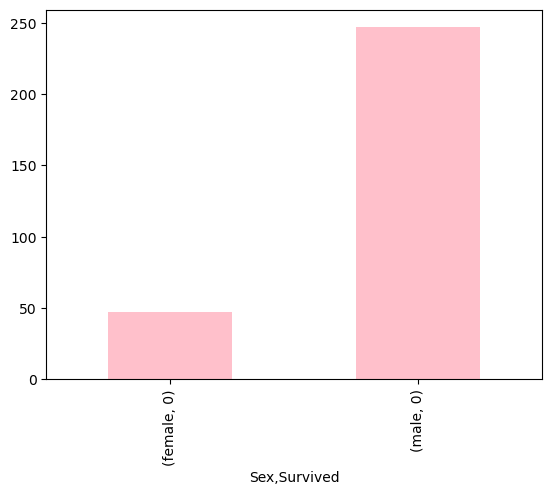

In [89]:
didnt_survive = test_df[test_df["Survived"] == 0]
gender_didnt_survive = didnt_survive.groupby("Sex")
gender_didnt_survive["Survived"].value_counts().plot(kind="bar", color="pink");